## Further text preprocessing

### Objectives of this test

- Implement Latent Dirichlet Allocation (**LDA**) from **Gensim** package along with the Mallet’s implementation (via Gensim). 

- Implement **Mallet** that optimizes LDA. Mallet is known to run faster and gives better topic segregation.

- Also extract the volume and percentage contribution of each topic to get **an idea of how important a topic is**.

### Pre-requisites: Downloading NLTK Dutch stopwords, data handling tools, model preprocessing & plotting tools, and SpaCy model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
# NLTK
import nltk
nltk.download('stopwords', 'dutch')

[nltk_data] Downloading package stopwords to dutch...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
# Python data analysis tools and python module for printing
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [25]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [26]:
# SpaCy for lemmatization
import spacy

In [27]:
# Plotting tools
#!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt

In [28]:
# Ignoring warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

### Preparing stopwords

In [29]:
# NLTK Stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = nltk.corpus.stopwords.words('dutch')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wvdvijve/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading 628 articles into a list

In [30]:
# Importing file handling library
import os

data = []
path = './data/clean_articles/'
for name in os.listdir(path):
    with open(path+name, 'r') as file:
        data.append(file.read())


### Tokenizing words and cleaning-up text

In [31]:
# Tokenizing each sentence into a list of words, removing punctuations and unnecessary characters altogether.
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

#print(data_words)

### Creating bigrams and trigrams

**Bigrams** are two (2) words frequently occurring together in the document. **Trigrams** are three (3) words frequently occurring.

In [32]:
# Building the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Seeing trigram example
#print(trigram_mod[bigram_mod[data_words]])

###  Removing stopwords, making bigrams & trigtrams, and lemmatizing

In [33]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

empty_words = [
    'advies',
    'algemeen',
    'art',
    'artikel',
    'bedoelen',
    'bepalen',
    'bepaling',
    'besluit',
    'betreffen',
    'bevoegd',
    'deel',
    'drie',
    'een',
    'één',
    'gegeven',
    'gelet',
    'geven',
    'goed',
    'hoofdstuk',
    'inlichting',
    'lid',
    'leten',
    'maatregel',
    'minister',
    'naam',
    'nemen',
    'ontwerp',
    'overwegen',
    'overwegende',
    'paragraaf',
    'persoon',
    'toepassing',
    'twee',
    'volgen',
    'voorzien',
    'wet'
] 

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if (token.pos_ in allowed_postags) and (token.lemma_ not in  empty_words )])
    return texts_out

### Initializing SpaCy's Dutch NLP model (large size)

In [12]:
#!pip install -U spacy
#!python -m spacy download nl_core_news_sm

### Calling the functions in order

In [34]:
 # Removing Stop Words
data_words_nostops = remove_stopwords(data_words)

# Forming Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Loading the SpaCy 'nl' model, keeping only tagger component (for efficiency)
nlp = spacy.load('nl_core_news_sm', disable=['parser', 'ner'])

# Doing lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized)

### Creating the Dictionary and Corpus needed for Topic Modeling

In [14]:
# Creating Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Creating Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Viewing corpus
#print(corpus)

In [78]:
import joblib


In [79]:
joblib.dump(texts, './models/corpus')

['./models/corpus']

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, **word id 0 occurs once** in the document. Likewise, **word id 1 occurs once too**, and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary. (From https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

In [35]:
# Passing the id as a key to the dictionary to see what word a given ID corresponds to
id2word[0]

'Frans'

In [16]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus]

[[('Frans', 1),
  ('Integratie', 1),
  ('aangevraagd', 1),
  ('aanhef', 1),
  ('aanhefbepaling', 1),
  ('aanleiding', 2),
  ('aantal', 2),
  ('aanvraag', 2),
  ('aanvrag', 1),
  ('activiteit', 3),
  ('adviesaanvraag', 1),
  ('afdeling_wetgeving', 4),
  ('alleen', 1),
  ('anderzijds', 1),
  ('armoede', 2),
  ('auditeur', 1),
  ('bedoeld', 1),
  ('bedrag', 1),
  ('bedrijf', 1),
  ('begroting', 1),
  ('belangrijk', 3),
  ('belasten', 1),
  ('beogen', 1),
  ('beperken', 2),
  ('beperking', 1),
  ('beroep', 2),
  ('bestaan', 1),
  ('betalen', 1),
  ('bevinden', 1),
  ('bevoegdheid', 1),
  ('bieden', 1),
  ('bij_komen', 2),
  ('bijzonder', 2),
  ('blootgesteld', 1),
  ('brengen', 1),
  ('centrum', 1),
  ('crisis', 9),
  ('crisistoestand', 1),
  ('deele_conomie', 1),
  ('deeltijds', 1),
  ('dienen', 2),
  ('doel', 1),
  ('doen', 1),
  ('dreigen', 1),
  ('dringend', 1),
  ('echter', 2),
  ('economisch', 2),
  ('eer', 1),
  ('effect', 1),
  ('eigen', 1),
  ('enerzijds', 1),
  ('enkel', 1),
  ('

### Building the topic model

The LDA model shall be built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

In [36]:
# Building LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

###  Viewing the topics in LDA model

You can see the keywords for each topic and the weightage (importance) of each keyword using lda_model.print_topics() as shown next.

In [37]:
# Printing keywords for 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.024*"bedrag" + 0.021*"woord" + 0.021*"wet_boek" + 0.018*"maand" + '
  '0.016*"jaar" + 0.015*"vervangen" + 0.013*"hetzelfde" + 0.012*"vennootschap" '
  '+ 0.012*"betrekking" + 0.011*"btw"'),
 (1,
  '0.012*"periode" + 0.010*"termijn" + 0.009*"raad" + 0.007*"activiteit" + '
  '0.007*"ministerieel" + 0.006*"voorwaarde" + 0.006*"verspreiding" + '
  '0.006*"maand" + 0.006*"aantal" + 0.006*"erkenning"'),
 (2,
  '0.047*"ziekenhuis" + 0.036*"bericht" + 0.032*"geneeskundige_verzorging" + '
  '0.031*"patiënt" + 0.022*"tegemoetkoming" + 0.020*"verplichte_verzekering" + '
  '0.017*"financiele_tussenkomst" + 0.017*"zorgverlener" + 0.016*"arts" + '
  '0.014*"verlenen"'),
 (3,
  '0.053*"code" + 0.040*"onderneming" + 0.017*"tegemoetkoming" + '
  '0.015*"sector" + 0.013*"regering" + 0.013*"activiteit" + 0.013*"decreet" + '
  '0.012*"raad" + 0.012*"euro" + 0.012*"vergoeding"'),
 (4,
  '0.059*"regering" + 0.038*"waals" + 0.035*"decreet" + 0.029*"woord" + '
  '0.021*"kader" + 0.019*"vervangen" + 

**NOTE**: 

The weights reflect how important a keyword is to that topic.

Looking at these keywords, you can guess what this topic could be.

### Compute Model Perplexity and Coherence Score

**Model perplexity** and **topic coherence** provide a convenient measure to judge how good a given topic model is.

In [38]:
# Computing Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Computing Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.865873610939735

Coherence Score:  0.48796713305020656


### Visualizing topic-keywords distribution

In [39]:
# Feeding the model into the pyLDAvis instance
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/Users/wvdvijve/Documents/GitHub/becode-projects/KPMG_NLP_project/env/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/wvdvijve/Documents/GitHub/becode-projects/KPMG_NLP_project/env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/wvdvijve/Documents/GitHub/becode-projects/KPMG_NLP_project/env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/wvdvijve/Documents/GitHub/becode-projects/KPMG_NLP_project/env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning:

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.194249 -0.084660       1        1  20.226043
5      0.161256 -0.112303       2        1  19.034619
17     0.190499 -0.018480       3        1   9.390488
19     0.177115  0.080095       4        1   8.687141
10     0.156773 -0.187559       5        1   8.365954
0      0.144622 -0.154703       6        1   6.727432
4      0.157178  0.199069       7        1   6.192313
12     0.024628  0.127033       8        1   3.444797
3      0.165851  0.091879       9        1   3.369271
16     0.039083  0.144743      10        1   3.250689
2     -0.058415 -0.137322      11        1   2.509899
14    -0.017710  0.141205      12        1   2.450372
13    -0.013085 -0.030408      13        1   1.647113
9     -0.116702 -0.064563      14        1   1.083895
15    -0.195476  0.004045      15        1   0.834380
8     -0.163887 -0.038064      16        1   0.810602
11    -0.218764  0.012469      17        1   0.777856
6     -0.236581 -0.043443      18        1   0.614082
18    -0.128181  0.093304      19        1   0.564072
7     -0.262454 -0.022338      20        1   0.018981, topic_info=                  Term         Freq        Total Category  logprob  loglift
129           regering  2599.000000  2599.000000  Default  30.0000  30.0000
86          koninklijk  2104.000000  2104.000000  Default  29.0000  29.0000
1028         vermelden  1351.000000  1351.000000  Default  28.0000  28.0000
574            decreet  1699.000000  1699.000000  Default  27.0000  27.0000
787             Vlaams   738.000000   738.000000  Default  26.0000  26.0000
...                ...          ...          ...      ...      ...      ...
10928     kortverblijf     0.003277     1.050731  Topic20  -9.7484   2.7992
8225       viormeldeen     0.003277     1.050707  Topic20  -9.7484   2.7992
7894       staatssteun     0.003277     1.050726  Topic20  -9.7484   2.7992
9037       vrijgemaken     0.003277     1.050703  Topic20  -9.7484   2.7992
4041   opgroeien_regie     0.003277    15.384505  Topic20  -9.7484   0.1154

[1253 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
6089     16  0.853564      Aangelegenheid
2594     18  0.897454         Alternatief
5677     18  0.925193             Avenant
1490     16  0.791512                Bars
202       2  0.737325            Belgisch
...     ...       ...                 ...
3743      2  0.113909        zorgverlener
3743     11  0.875674        zorgverlener
6482     14  0.956015  zulks_schriftelijk
201       3  0.852529         zullen_onze
201      13  0.140474         zullen_onze

[2832 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 18, 20, 11, 1, 5, 13, 4, 17, 3, 15, 14, 10, 16, 9, 12, 7, 19, 8])

**How to make inferences from pyLDAvis' output:**

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

## Mallet's version of LDA

Up next, we will improve upon this model by using **Mallet’s version of LDA algorithm** and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. 

In [21]:
# Upgrading Gensim
# Updated to enforce Gensim v3.8 in Colab (the last version to support running topic models via Mallet).
# https://github.com/polsci/colab-gensim-mallet
# !pip install --upgrade gensim==3.8

In [22]:
# Installing Mallet
# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

zsh:1: command not found: wget
unzip:  cannot find or open mallet-2.0.8.zip, mallet-2.0.8.zip.zip or mallet-2.0.8.zip.ZIP.


In [56]:
mallet_path = './mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 7980
total tokens: 295439
<10> LL/token: -9,20771
<20> LL/token: -8,55999
<30> LL/token: -8,39469
<40> LL/token: -8,31835

0	2,5	waals decreet overeenkomst bevoegde_autoriteit akkoord belasting brussel_fiscaliteit regering generaal bevoegdheid dag financiën groot fiscaliteit geval aanwezig overheidsd_ienst voorzitter dienst wijzigen 
1	2,5	fiscaal kennisgeving bericht administratie procedure elektronisch waarbij datum middel gebrek gewestelijk gebruiken geval dergelijk ordonnantie verze_nding bedrag mee_delen natuurlijke_persoon gemeente 
2	2,5	onderwijs leerling decreet school personeel_lid afwijking school_jaar organisatie betrekking personeelslid kind personeel hoog promotie secundair_onderwijs organiseren graad opleiding extra stellen 
3	2,5	koninklijk zelfstandig periode sociaal tijdelijk kader covid datum wijziging uitkering houden maand pandemie houd_en raad uitwerking invoering dringend omwille ingan

In [57]:
# Showing Topics
pprint(ldamallet.show_topics(formatted=False))

[(2,
  [('onderwijs', 0.0340765671013883),
   ('decreet', 0.03211330809143178),
   ('leerling', 0.025522367129434863),
   ('regering', 0.014724442574673959),
   ('school', 0.014443977001823026),
   ('school_jaar', 0.013883045856121162),
   ('afwijking', 0.013742813069695695),
   ('organisatie', 0.01297153274435563),
   ('sociaal', 0.012691067171504698),
   ('organiseren', 0.012200252419015565)]),
 (17,
  [('kader', 0.01545914369167201),
   ('contact', 0.011327206668091472),
   ('categorie', 0.010401082852461352),
   ('digitaal', 0.010116121678421314),
   ('gegevensbank', 0.010116121678421314),
   ('verwerking', 0.009189997862791194),
   ('vermelden', 0.008833796395241148),
   ('agentschap', 0.008762556101731139),
   ('gezondheid', 0.008335114340671083),
   ('nodig', 0.007978912873121037)]),
 (0,
  [('akkoord', 0.026102610261026102),
   ('betrekking', 0.022614761476147615),
   ('bevoegde_autoriteit', 0.022614761476147615),
   ('overeenkomst', 0.02193969396939694),
   ('brussel_fiscalite

In [58]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5312195858405495


**NOTE:** A *remarkable increase* in **coherence score** from  **0.4755895419687482** to **0.5263633698781748**.

In [59]:
mallet_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet, gamma_threshold=0.001, iterations=50)

In [71]:
from gensim.test.utils import datapath

# Save model to disk.

temp_file = datapath("/Users/wvdvijve/Documents/GitHub/becode-projects/KPMG_NLP_project/models/mallet")

mallet_model.save(temp_file)

In [60]:
vis_2 = gensimvis.prepare(mallet_model, corpus, id2word)
vis_2

/Users/wvdvijve/Documents/GitHub/becode-projects/KPMG_NLP_project/env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/wvdvijve/Documents/GitHub/becode-projects/KPMG_NLP_project/env/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/wvdvijve/Documents/GitHub/becode-projects/KPMG_NLP_project/env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/wvdvijve/Documents/GitHub/becode-projects/KPMG_NLP_project/env/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__versi

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6     -0.068119  0.124388       1        1  8.513949
7      0.043433 -0.075427       2        1  5.993801
12     0.140979  0.064986       3        1  5.645018
5      0.018819  0.192136       4        1  5.628572
19    -0.197874 -0.079147       5        1  5.592528
4     -0.005362  0.076959       6        1  5.387376
18     0.194864 -0.073374       7        1  5.318539
3      0.060504 -0.150023       8        1  5.229817
15    -0.025561 -0.007762       9        1  5.066487
14    -0.172211 -0.207718      10        1  4.953539
9     -0.052472 -0.075636      11        1  4.922321
17    -0.026367  0.188873      12        1  4.913654
11    -0.134048 -0.067447      13        1  4.807393
2      0.158156  0.018850      14        1  4.746824
16     0.236137 -0.076669      15        1  4.524538
13     0.140800 -0.138150      16        1  4.474596
1     -0.124744  0.033232      17        1  3.980181
8      0.056737  0.200115      18        1  3.786758
10    -0.098055 -0.041844      19        1  3.587543
0     -0.145616  0.093658      20        1  2.926564, topic_info=               Term         Freq        Total Category  logprob  loglift
2222          woord  1363.000000  1363.000000  Default  30.0000  30.0000
129        regering  2639.000000  2639.000000  Default  29.0000  29.0000
86       koninklijk  1884.000000  1884.000000  Default  28.0000  28.0000
1396      vervangen  1281.000000  1281.000000  Default  27.0000  27.0000
574         decreet  1723.000000  1723.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
706   administratie    75.943331   580.445960  Topic20  -4.7357   1.4975
54         federaal    66.207006   497.892505  Topic20  -4.8729   1.5137
1055           zaak    59.391579   318.490957  Topic20  -4.9816   1.8519
1302       wijzigen    64.259741   671.148477  Topic20  -4.9028   1.1853
1391      verlengen    51.602520   399.138775  Topic20  -5.1222   1.4856

[1885 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2593     10  0.993291     Aanvoeren
1062      4  0.991270         Alpha
2594      9  0.996980   Alternatief
1490      3  1.015401          Bars
7269     16  1.018058           Bel
...     ...       ...           ...
3743     12  0.077657  zorgverlener
201       8  0.684194   zullen_onze
201      11  0.067742   zullen_onze
201      19  0.243871   zullen_onze
2862      6  0.988004      zuurstof

[3805 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 13, 6, 20, 5, 19, 4, 16, 15, 10, 18, 12, 3, 17, 14, 2, 9, 11, 1])

### Finding the optimal number of topics for LDA

The approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

In [62]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values

In [63]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 7980
total tokens: 295439
<10> LL/token: -8,55212
<20> LL/token: -8,37999
<30> LL/token: -8,32907
<40> LL/token: -8,30261

0	25	regering decreet woord vermelden kader vervangen koninklijk Vlaams dag periode afwijking betrekking datum tijdelijk houd_en geval raad belasten uitvoering sociaal 
1	25	onderneming activiteit koninklijk regering raad steun bijzonder regeling houden bedrag voorwaarde gevolg wet_boek betrekking dienst uitvoering euro kader maand dringend 

<50> LL/token: -8,29035
<60> LL/token: -8,28039
<70> LL/token: -8,27213
<80> LL/token: -8,266
<90> LL/token: -8,26109

0	25	regering decreet woord vermelden kader vervangen dag Vlaams afwijking belasten houd_en datum betrekking organisatie raad periode subsidie geval hetzelfde uitvoering 
1	25	koninklijk onderneming activiteit raad steun houden bedrag regeling bijzonder voorwaarde wet_boek betrekking sociaal gevolg kader uitvoering periode maand werkneme

KeyboardInterrupt: 

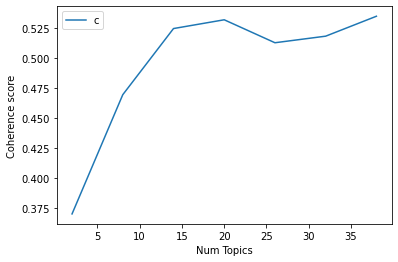

In [ ]:
# Showing graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

**NOTE:**
The optimal **coherence score** shown in this plot lies **around 6-8 number of topics**.

In [ ]:
# Printing the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.37
Num Topics = 8  has Coherence Value of 0.4693
Num Topics = 14  has Coherence Value of 0.5243
Num Topics = 20  has Coherence Value of 0.5317
Num Topics = 26  has Coherence Value of 0.5125
Num Topics = 32  has Coherence Value of 0.518
Num Topics = 38  has Coherence Value of 0.5346


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out.

### Choosing the model with fourteen (14) topics

In [ ]:
# Select the model and print the topics
# The best LDA model with the optimal coherence score has 14 topics, which is
# index 2 from the model_list list
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(14,
  '0.018*"raad" + 0.015*"koninklijk" + 0.012*"ontwerpen" + 0.011*"termijn" + '
  '0.011*"verslag" + 0.010*"koning" + 0.009*"tekst" + 0.009*"opmerking" + '
  '0.009*"regeling" + 0.009*"wijziging"'),
 (20,
  '0.057*"steun" + 0.022*"onderneming" + 0.019*"activiteit" + '
  '0.019*"begunstigen" + 0.017*"economisch" + 0.013*"economie" + '
  '0.011*"sociaal" + 0.009*"premie" + 0.009*"voorwaarde" + 0.009*"verlenen"'),
 (25,
  '0.059*"Vlaams" + 0.040*"vermelden" + 0.029*"regering" + 0.028*"decreet" + '
  '0.021*"subsidie" + 0.019*"ondersteuning" + 0.014*"organisatie" + '
  '0.012*"financieel" + 0.011*"periode" + 0.010*"euro"'),
 (0,
  '0.020*"personeel_lid" + 0.018*"kader" + 0.013*"personeelslid" + '
  '0.012*"werk" + 0.011*"personeel" + 0.011*"dienst" + 0.011*"dag" + '
  '0.010*"kind" + 0.010*"taak" + 0.009*"functie"'),
 (8,
  '0.042*"ziekenhuis" + 0.023*"overeenkomst" + 0.021*"akkoord" + '
  '0.015*"brussel_fiscaliteit" + 0.014*"tegemoetkoming" + 0.013*"epidemie" + '
  '0.013*"financiee

In [ ]:
final_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model, gamma_threshold=0.001, iterations=50)

In [ ]:
vis_3 = gensimvis.prepare(final_model, corpus, id2word)
vis_3

/Users/wvdvijve/Documents/GitHub/becode-projects/KPMG_NLP_project/env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/wvdvijve/Documents/GitHub/becode-projects/KPMG_NLP_project/env/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/wvdvijve/Documents/GitHub/becode-projects/KPMG_NLP_project/env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/wvdvijve/Documents/GitHub/becode-projects/KPMG_NLP_project/env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9     -0.093135 -0.117323       1        1  7.586012
14     0.018979 -0.043064       2        1  5.763660
12    -0.218520  0.020887       3        1  4.562955
5     -0.050371  0.019034       4        1  4.505212
15     0.120088 -0.078356       5        1  4.483897
22     0.048837 -0.192282       6        1  4.433952
20     0.058815  0.048902       7        1  4.240164
18     0.059801 -0.166027       8        1  4.102584
11    -0.078444  0.038523       9        1  4.053568
7      0.103308  0.090954      10        1  4.002821
25     0.080475  0.124847      11        1  3.985741
1      0.095658  0.076031      12        1  3.941928
4      0.056077  0.127536      13        1  3.787800
19     0.059653 -0.082090      14        1  3.713621
3     -0.113694  0.088648      15        1  3.633384
23    -0.281737  0.087619      16        1  3.601098
6      0.083405 -0.112711      17        1  3.480435
0      0.106700 -0.183176      18        1  3.385485
2     -0.028450  0.033699      19        1  3.366080
16     0.182014  0.168645      20        1  3.352765
10     0.177396  0.236291      21        1  3.261567
8     -0.048096  0.001724      22        1  3.036062
21    -0.206903 -0.010906      23        1  2.734299
13    -0.118358  0.052343      24        1  2.484379
24     0.062401 -0.188315      25        1  2.457107
17    -0.075899 -0.041436      26        1  2.043423, topic_info=            Term         Freq        Total Category  logprob  loglift
2227       woord  1369.000000  1369.000000  Default  30.0000  30.0000
130     regering  2637.000000  2637.000000  Default  29.0000  29.0000
574      decreet  1710.000000  1710.000000  Default  28.0000  28.0000
86    koninklijk  1860.000000  1860.000000  Default  27.0000  27.0000
1400   vervangen  1283.000000  1283.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
578       dienst    41.055119   967.139419  Topic26  -5.0156   0.7311
54      federaal    36.949608   525.585794  Topic26  -5.1210   1.2356
1177       lijst    32.844096   299.451276  Topic26  -5.2388   1.6804
180      verzoek    30.791340   236.229960  Topic26  -5.3033   1.8530
1306    wijzigen    28.738584   675.172813  Topic26  -5.3723   0.7338

[2413 rows x 6 columns], token_table=       Topic      Freq                      Term
term                                            
2597      16  1.010736                 Aanvoeren
7613      17  0.985634                  Addendum
1066      18  1.005378                     Alpha
2598      17  0.985634               Alternatief
10074     25  0.902444                    August
...      ...       ...                       ...
201       12  0.878494               zullen_onze
201       19  0.119475               zullen_onze
15384     25  1.002716  zusta_ndigen_foderierten
15388     25  0.992688   zustandigen_foderierten
2865      14  0.988557                  zuurstof

[5031 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 15, 13, 6, 16, 23, 21, 19, 12, 8, 26, 2, 5, 20, 4, 24, 7, 1, 3, 17, 11, 9, 22, 14, 25, 18])

### Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the **topic number that has the highest percentage contribution** in the document/set of documents.

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_words)

/var/folders/1j/th1xcyq15k75p76l91zqndh40000gn/T/ipykernel_19792/2126665030.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/1j/th1xcyq15k75p76l91zqndh40000gn/T/ipykernel_19792/2126665030.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


In [ ]:
# Formatting
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Showing
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               1              0.3726   
1            1              12              0.5637   
2            2               2              0.3568   
3            3               2              0.5750   
4            4               3              0.1949   
5            5               3              0.1573   
6            6               5              0.1803   
7            7               4              0.4447   
8            8               4              0.7705   
9            9               6              0.2752   

                                            Keywords  \
0  koninklijk, tijdelijk, zelfstandig, periode, s...   
1  ziekenhuis, patiënt, koninklijk, geneeskundige...   
2  regering, brusselse_hoofdstedelijk, ordonnanti...   
3  regering, brusselse_hoofdstedelijk, ordonnanti...   
4  onderneming, steun, activiteit, code, economie...   
5  onderneming, steun, activiteit, code, economie...   
6  decreet, onderwijs, leerling, regering, afwijk...   
7  kader, verspreiding, contact, mogelijk, federa...   
8  kader, verspreiding, contact, mogelijk, federa...   
9  wet_boek, belasting, koninklijk, regeling, bet...   

                                                Text  
0  [verslag, aan, de, koning, sire, het, ontwerpb...  
1  [gelet, op, de, wet, van, maart, op, de, genee...  
2  [de, verenigde, vergadering, heeft, aangenomen...  
3  [de, brusselse, hoofdstedelijke, regering, gel...  
4  [de, regering, van, de, franse, gemeenschap, g...  
5  [het, gedeelte, van, de, dat, toe, te, schrijv...  
6  [de, regering, van, de, franse, gemeenschap, g...  
7  [bij, de, verordening, betreffende, een, kader...  
8  [het, verenigd, college, van, de, gelet, op, d...  
9  [filip, koning, der, belgen, aan, allen, die, ...

### Finding the most representative document for each topic

With understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [ ]:
# Grouping the top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reseting Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Formating
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Showing
sent_topics_sorteddf_mallet.head()

Topic_Num  Topic_Perc_Contrib  \
0          0              0.8854   
1          1              0.7757   
2          2              0.7209   
3          3              0.8419   
4          4              0.7705   

                                            Keywords  \
0  jaar, vennootschap, maand, geval, aandeel, bet...   
1  koninklijk, tijdelijk, zelfstandig, periode, s...   
2  regering, brusselse_hoofdstedelijk, ordonnanti...   
3  onderneming, steun, activiteit, code, economie...   
4  kader, verspreiding, contact, mogelijk, federa...   

                                                Text  
0  [startende, vennootschappen, kunnen, moeilijkh...  
1  [filip, koning, der, belgen, aan, allen, die, ...  
2  [het, brusselse, hoofdstedelijke, parlement, h...  
3  [de, waalse, regering, gelet, op, het, decreet...  
4  [het, verenigd, college, van, de, gelet, op, d...

The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The **Perc_Contribution column** is nothing but the percentage contribution of the topic in the given document.

## Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. 

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenatinate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

Dominant_Topic                                     Topic_Keywords  \
0                 1  koninklijk, tijdelijk, zelfstandig, periode, s...   
1                12  ziekenhuis, patiënt, koninklijk, geneeskundige...   
2                 2  regering, brusselse_hoofdstedelijk, ordonnanti...   
3                 2  regering, brusselse_hoofdstedelijk, ordonnanti...   
4                 3  onderneming, steun, activiteit, code, economie...   
..              ...                                                ...   
623               6  wet_boek, belasting, koninklijk, regeling, bet...   
624               1  koninklijk, tijdelijk, zelfstandig, periode, s...   
625               1  koninklijk, tijdelijk, zelfstandig, periode, s...   
626               3  onderneming, steun, activiteit, code, economie...   
627              12  ziekenhuis, patiënt, koninklijk, geneeskundige...   

     Num_Documents  Perc_Documents  
0             17.0          0.0271  
1             78.0          0.1242  
2             91.0          0.1449  
3             59.0          0.0939  
4             34.0          0.0541  
..             ...             ...  
623            NaN             NaN  
624            NaN             NaN  
625            NaN             NaN  
626            NaN             NaN  
627            NaN             NaN  

[628 rows x 4 columns]

## CONCLUSION

From ten (10) Dutch legal text files that were cleaned, further ML preprocessing and unsupervised topic extraction were carried out via:

- A basic topic model using Gensim’s LDA; 

- pyLDAvis for topic visualisation; and 

- Mallet’s LDA implementation.